In [1]:
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
# import random
# import time

# import matplotlib
# import matplotlib.pyplot as plt
# import mplfinance as mpf
# sys.stdout=stdout
# import numpy as np
# import numpy as np
# import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd

# stock = '000001'  # 股票代码，注意是深圳或者上海市场的代码
# data = tdd.get_tdx_Exp_day_to_df(stock, start='20200101', end='20250215', resample='d').sort_index(ascending=False)
# # print(data.columns.tolist())
# data['trade_date'] = data.index
# print(data[-2:].trade_date)

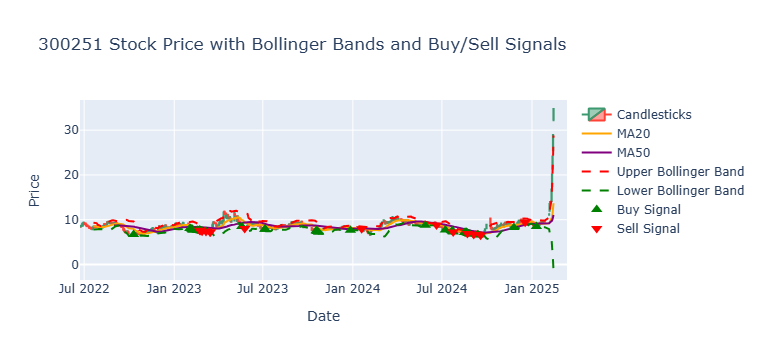

Buy signals:
            close  Low_min
trade_date                
2022-10-10   6.71     6.68
2023-02-02   8.05     8.02
2023-02-03   8.03     7.99
2023-02-06   7.91     7.86
2023-02-07   7.81     7.78
2023-02-08   7.67     7.64
2023-02-17   7.65     7.60
2023-02-21   7.65     7.60
2023-02-22   7.63     7.57
2023-02-23   7.60     7.57
2023-02-24   7.55     7.52
2023-02-27   7.45     7.42
2023-03-07   7.39     7.39
2023-05-19   8.48     8.42
2023-07-05   7.87     7.83
2023-07-06   7.87     7.83
2023-10-18   7.52     7.49
2023-10-19   7.50     7.47
2023-10-20   7.36     7.33
2023-10-23   7.23     7.18
2023-12-27   7.66     7.60
2024-05-28   8.76     8.72
2024-07-08   7.69     7.65
2024-07-22   7.52     7.46
2024-07-23   7.35     7.35
2024-07-24   7.24     7.21
2024-08-16   7.15     7.12
2024-08-19   7.19     7.12
2024-08-20   7.14     7.07
2024-08-21   7.07     7.06
2024-08-23   6.90     6.87
2024-08-27   6.76     6.74
2024-09-12   6.66     6.60
2024-09-13   6.59     6.58
2024-11-25   8.

In [10]:
# import tushare as ts
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

stock ='300251'
data = tdd.get_tdx_Exp_day_to_df(stock, start='20200101', end='20250215', resample='d').sort_index(ascending=False)
data['trade_date'] = data.index


# 数据预处理
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.set_index('trade_date', inplace=True)
data.sort_index(ascending=True, inplace=True)

# 计算移动平均线
data['MA20'] = data['close'].rolling(window=20).mean()
data['MA50'] = data['close'].rolling(window=50).mean()

# 计算布林带（Bollinger Bands）
data['stddev'] = data['close'].rolling(window=20).std()
data['UpperBand'] = data['MA20'] + (data['stddev'] * 2)
data['LowerBand'] = data['MA20'] - (data['stddev'] * 2)

# 计算MACD
data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 计算局部高低点（过去20天的最高和最低）
data['High_max'] = data['high'].rolling(window=20).max()
data['Low_min'] = data['low'].rolling(window=20).min()

# 计算成交量的5日均值
data['Vol_MA5'] = data['vol'].rolling(window=5).mean()

# 判断新高
data['New_High'] = data['close'] == data['High_max']

# 判断MACD死叉（MACD线从上向下穿越Signal线）
data['MACD_Cross'] = (data['MACD'] < data['Signal']) & (data['MACD'].shift(1) > data['Signal'].shift(1))

# 买点信号：股价接近布林带下轨并且接近最低点
data['Buy_Signal'] = (data['close'] < data['Low_min'] * 1.01) & (data['close'] > data['LowerBand'])

# 卖点信号：在买点后的持有期内，若股价未创新高且出现以下任一条件，则触发卖点
holding_period = 20  # 持有期设定为20天
price_drop_threshold = 0.05  # 价格下跌阈值设定为5%

# 创建一个空的列来存放修正后的卖点信号
data['Sell_Signal'] = False

# 遍历数据，修正卖点信号
for i in range(len(data) - holding_period):
    if data['Buy_Signal'].iloc[i]:
        # 从买点之后的20天内，检查是否满足卖点条件
        for j in range(i + 1, i + holding_period + 1):
            if not data['New_High'].iloc[j]:  # 股价未创新高
                if data['MACD_Cross'].iloc[j] or data['close'].iloc[j] <= data['close'].iloc[i] * (1 - price_drop_threshold):
                    data['Sell_Signal'].iloc[j] = True
                    break

# 可视化部分：使用plotly实现交互式图表
fig = make_subplots(rows=1, cols=1)

# 添加股价线
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['open'], high=data['high'],
                             low=data['low'], close=data['close'],
                             name='Candlesticks'))

# 添加MA20和MA50
fig.add_trace(go.Scatter(x=data.index, y=data['MA20'], mode='lines', name='MA20', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=data.index, y=data['MA50'], mode='lines', name='MA50', line=dict(color='purple')))

# 添加布林带
fig.add_trace(go.Scatter(x=data.index, y=data['UpperBand'], mode='lines', name='Upper Bollinger Band', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=data.index, y=data['LowerBand'], mode='lines', name='Lower Bollinger Band', line=dict(color='green', dash='dash')))

# 添加买点和卖点信号
fig.add_trace(go.Scatter(x=data.index[data['Buy_Signal'] == True], y=data['close'][data['Buy_Signal'] == True], 
                         mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=10)))

fig.add_trace(go.Scatter(x=data.index[data['Sell_Signal'] == True], y=data['close'][data['Sell_Signal'] == True], 
                         mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=10)))

# 设置图表标题
fig.update_layout(title=f'{stock} Stock Price with Bollinger Bands and Buy/Sell Signals',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

# 显示图表
fig.show()

# 输出买点和卖点信息
print("Buy signals:")
print(data[data['Buy_Signal'] == True][['close', 'Low_min']])
print("\nSell signals:")
print(data[data['Sell_Signal'] == True][['close', 'High_max']])
 


In [11]:
# import matplotlib
# import matplotlib.pyplot as plt

# %matplotlib widget
# plt.rc('font', family='SimHei', size=13)
# matplotlib.get_backend()
# # jupyter nbextension enable --py widgetsnbextension

# os.environ['NUMEXPR_MAX_THREADS'] = '12'
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"

%matplotlib widget
%matplotlib inline
# %matplotlib ipympl

In [12]:
# import tushare as ts
import pandas as pd
import backtrader as bt

# # 设置Tushare Token
# ts.set_token('your_tushare_token')  # 替换为你的Tushare API Token
# pro = ts.pro_api()

# # 获取股票数据，注意是股票代码格式：'000001.SZ'（深圳）或'600000.SH'（上海）
# stock = '300251.SZ'  # 示例：光线传媒股票
# data = pro.daily(ts_code=stock, start_date='20200101', end_date='20250215')

stock ='300251'
data = tdd.get_tdx_Exp_day_to_df(stock, start='20200101', end='20250215', resample='d').sort_index(ascending=False)
data['trade_date'] = data.index

# 数据预处理
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.set_index('trade_date', inplace=True)
data.sort_index(ascending=True, inplace=True)

# 计算移动平均线
data['MA20'] = data['close'].rolling(window=20).mean()
data['MA50'] = data['close'].rolling(window=50).mean()

# 计算布林带（Bollinger Bands）
data['stddev'] = data['close'].rolling(window=20).std()
data['UpperBand'] = data['MA20'] + (data['stddev'] * 2)
data['LowerBand'] = data['MA20'] - (data['stddev'] * 2)

# 计算MACD
data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 计算局部高低点（过去20天的最高和最低）
data['High_max'] = data['high'].rolling(window=20).max()
data['Low_min'] = data['low'].rolling(window=20).min()

# 计算成交量的5日均值
data['Vol_MA5'] = data['vol'].rolling(window=5).mean()

# 判断新高
data['New_High'] = data['close'] == data['High_max']

# 判断MACD金叉（MACD线穿越Signal线）
data['MACD_Cross'] = (data['MACD'] > data['Signal']) & (data['MACD'].shift(1) < data['Signal'].shift(1))

# 买点信号：股价接近布林带下轨并且接近最低点
data['Buy_Signal'] = (data['close'] < data['Low_min'] * 1.01) & (data['close'] > data['LowerBand'])

# 卖点信号：在买点后的持有期内，若股价未创新高且出现以下任一条件，则触发卖点
holding_period = 20  # 持有期设定为20天
price_drop_threshold = 0.05  # 价格下跌阈值设定为5%

# 创建一个空的列来存放修正后的卖点信号
data['Sell_Signal'] = False

# 遍历数据，修正卖点信号
for i in range(len(data) - holding_period):
    if data['Buy_Signal'].iloc[i]:
        # 从买点之后的20天内，检查是否满足卖点条件
        for j in range(i + 1, i + holding_period + 1):
            if not data['New_High'].iloc[j]:  # 股价未创新高
                if data['MACD_Cross'].iloc[j] or data['close'].iloc[j] <= data['close'].iloc[i] * (1 - price_drop_threshold):
                    data['Sell_Signal'].iloc[j] = True
                    break

# 将数据转换为backtrader的格式
class StockData(bt.feeds.PandasData):
    lines = ('Buy_Signal', 'Sell_Signal')
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'vol'),
        ('openinterest', None),
        ('Buy_Signal', -1),
        ('Sell_Signal', -1)
    )

# 创建策略
class BollingerMACDStrategy(bt.SignalStrategy):
    def __init__(self):
        # 添加买入信号
        self.signal_add(bt.SIGNAL_LONG, self.data.Buy_Signal)
        # 添加卖出信号
        self.signal_add(bt.SIGNAL_SHORT, self.data.Sell_Signal)

# 创建回测引擎
cerebro = bt.Cerebro()
cerebro.addstrategy(BollingerMACDStrategy)
# cerebro.plot(iplot = False)
# 加载数据
data_feed = StockData(dataname=data)
cerebro.adddata(data_feed)

# 设置初始资金
cerebro.broker.set_cash(100000)

# 设置佣金
cerebro.broker.setcommission(commission=0.005)

# 设置滑点
cerebro.broker.set_slippage_perc(0.001)

# 设置每笔交易的资金占比
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# 设置回测时间范围
# cerebro.broker.setstartdate(data.index[0])
# cerebro.broker.setenddate(data.index[-1])

# 运行回测
cerebro.run()

# 获取最终资金
final_value = cerebro.broker.getvalue()
print(f'最终资金：{final_value}')

# 绘制回测结果
cerebro.plot()


最终资金：100000.0


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

# 计算上涨通道可以使用回归分析。首先，您需要获取时间和价格数据，然后计算出回归方程。该方程将时间视为自变量，价格视为因变量，并通过最小二乘法拟合出一条线性回归线。您可以使用该回归线的方程来预测当前价格的位置。

以下是使用Python代码实现上述步骤的示例：

100.0 5.0


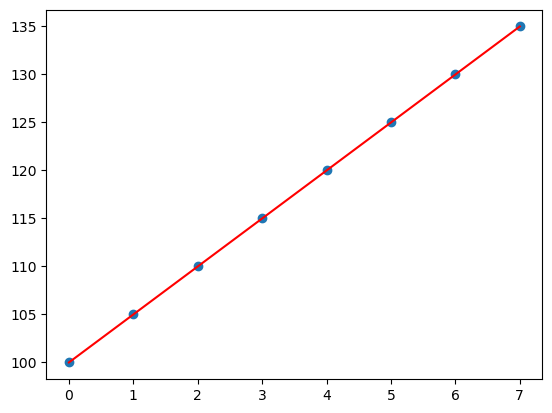

Below


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def regression_line(X, Y):
    # Calculate the coefficients of the regression line
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = (sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x)
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x)
    return a, b

def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price

def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()

def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"

# Example usage
time = np.array([0, 1, 2, 3, 4, 5, 6, 7])
price = np.array([100, 105, 110, 115, 120, 125, 130, 135])
a, b = regression_line(time, price)
print(a, b)
# Output: (100.0, 5.0)
plot_regression_line(time, price, a, b)
print(detect_position(132, a, b, time))
# Output: "On"


# 识别诱多诱空可以使用历史数据的高低点下降速度来进行判断。具体实现方法如下：

计算历史高低点：首先，您需要找出历史数据的高点和低点，并计算出它们的下降速度。

对比历史数据：使用当前数据的下降速度与历史数据的下降速度进行对比，以判断诱多诱空情况。如果当前数据的下降速度比历史数据更快，则可以认为是诱空，反之则可以认为是诱多。

下面是使用Python代码实现上述步骤的示例：

In [2]:
import numpy as np

def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = (data[1] - data[0]) / (1)
    return slope

def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        slopes.append(slope)
    
    # Compare the current slope with the average slope of the last `window` days
    avg_slope = np.mean(slopes)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    if curr_slope > avg_slope:
        return "Bullish"
    else:
        return "Bearish"

# Example usage
price_data = [100, 95, 97, 99, 102, 105, 108, 111]
print(detect_bull_bear(price_data))
# Output: "Bullish"

IndexError: list index out of range

# 代码里面如何加上成交量放大,缩量,一起计算买入卖出指标,
可以将成交量作为一个独立的变量，将其与价格一起作为回归分析的输入变量。如果成交量与价格同时升高，则可以视为有利买入信号；如果成交量下降而价格上升，则可以视为警告信号。

下面是示例代码，使用Scikit-learn库实现：

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# 加载数据
df = pd.read_csv("data.csv")

# 创建输入数据
X = df[["Price", "Volume"]].values
y = df["Price"].values

# 训练回归模型
reg = LinearRegression().fit(X, y)

# 计算斜率和截距
slope = reg.coef_[0]
intercept = reg.intercept_

# 计算上轨和下轨
upper_band = slope * df["Price"] + intercept + 2 * df["Volume"]
lower_band = slope * df["Price"] + intercept - 2 * df["Volume"]

# 判断价格是否在通道内
df["Position"] = np.where(df["Price"] > upper_band, "Long", np.where(df["Price"] < lower_band, "Short", "Neutral"))


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

# 下面是一段使用mplfinance的代码示例：

In [4]:


python
Copy code
import mplfinance as mpf
import pandas as pd

# Load and pre-process data
df = pd.read_csv('data.csv')
df['position'] = 0

# Compute the channel and update the position based on the current price
def compute_channel(df):
    # Compute the channel
    # ...

    # Update the position
    # ...

# Plot the ohlc chart
mpf.plot(df, type='candle', title='OHLC chart with channel and position',
         ylabel='Price', volume=True, mav=(10, 20),
         show_nontrading=False, ylabel_lower='Position',
         yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'])

SyntaxError: invalid syntax (4240433000.py, line 2)

# 加入了通道的计算代码，计算通道的上轨和下轨，并在计算完通道后利用当前价格来更新买卖的位置。然后用mplfinance绘制出K线图，显示成交量，上轨，下轨和当前位置。你可以根据自己的需求完善代码。

In [5]:
import mplfinance as mpf
import pandas as pd
import numpy as np

# Load and pre-process data
df = pd.read_csv('data.csv')
df['position'] = 0

# Compute the channel
def compute_channel(df):
    # Compute the high and low of the past n periods
    n = 20
    high = df['high'].rolling(window=n, min_periods=n).max()
    low = df['low'].rolling(window=n, min_periods=n).min()
    df['upper_channel'] = high + (high - low) * 0.5
    df['lower_channel'] = low - (high - low) * 0.5
    
    # Update the position based on the current price
    df['position'] = np.where(df['close'] > df['upper_channel'], 1,
                              np.where(df['close'] < df['lower_channel'], -1, 0))

compute_channel(df)

# Plot the ohlc chart
mpf.plot(df, type='candle', title='OHLC chart with channel and position',
         ylabel='Price', volume=True, mav=(10, 20),
         show_nontrading=False, ylabel_lower='Position',
         yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
         overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'